# Recognition using ConvNet

inspired by Leland Roberts. https://github.com/lelandroberts97/Musical_Genre_Classification/tree/master/code

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import pathlib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import librosa
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cornelius/anaconda3/envs/robocup/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cornelius/anaconda3/envs/rob

## 1. Inspect one song
This is to get a feeling for the data and the filters that we want to use

In [2]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
y, sr = librosa.load('genres/disco/disco.00000.wav')
y_rec, sr_rec = librosa.load("../../recordings/output.wav")

# Checking the audio wave and sampling rate
y.shape, sr, sr_rec

((664180,), 22050, 22050)

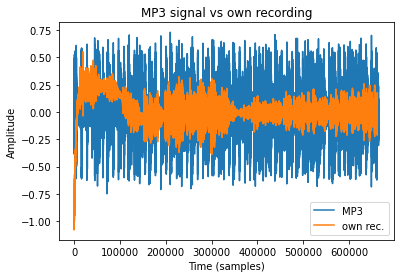

In [3]:
# Plotting the wave
plt.plot(y, label='MP3')
plt.plot(y_rec, label='own rec.')
plt.title('MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

As you can see, the shapes of the two waves differ substantially. The problem is that the one audio is a clean MP3 and te second audio is a phone recording of laptop output.

#### Filter
Hence, we use a filter to make signals be more similar.

In [4]:
def band_filter(file):
    lo, hi = 600,10000
    y, sr = librosa.load(file)
    b, a = butter(N=6, Wn=[2*lo/sr, 2*hi/sr], btype='band')
    x = lfilter(b,a,y)
    return x, sr

def compress_filter(file):
    y, sr = librosa.load(file)
    x = librosa.mu_compress(y, quantize=False)
    return x, sr

In [6]:
# now filter
#filtered_mp3,_ = band_filter('genres/disco/disco.00000.wav')
#filtered_rec,_ = band_filter("../recordings/output.wav")

filtered_mp3,_ = compress_filter('genres/disco/disco.00000.wav')
filtered_rec,_ = compress_filter("../../recordings/output.wav")

# Plotting the filtered waves
plt.plot(filtered_mp3, label='MP3')
plt.plot(filtered_rec, label='own rec.')
plt.title('Filtered MP3 signal vs own recording')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude');

ParameterError: mu-law input x=[-0.73689854 -1.0800318  -0.9519966  ...  0.04290927  0.04402272
 -0.02188273] must be in the range [-1, +1].

## 2. Read and extract Mel Spectrogram for audiofiles

In this step we get the data and write it to files in order to be faster in the later steps

In [76]:
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
#GENRES = ['classical', 'jazz', 'metal']

In [75]:
# Creating an empty list to store sizes in
sizes = []

# Looping through each audio file
# load all songs from the gtzan data set
for genre in GENRES:
    sound_files = glob.glob('genres/' + genre + '/*.wav')
    for file in sound_files:
        # Loading in the audio file
        y, sr = librosa.core.load(file)

        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)

        # Adding the size to the list
        sizes.append(spect.shape)
    
# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')


KeyboardInterrupt: 

In [82]:
def extract_mel_spectrogram():
    all_features = []
    all_labels = []

    # load all songs from the gtzan data set
    for genre in GENRES:
        sound_files = glob.glob('genres/' + genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for file in sound_files:
            # Loading in the audio file
            y, sr = librosa.core.load(file)
        
            # Computing the mel spectrograms
            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
            spect = librosa.power_to_db(spect, ref=np.max)

            # Adjusting the size to be 128 x 660
            if spect.shape[1] != 660:
                spect.resize(128,660, refcheck=False)

            all_features.append(spect)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))

    # store features and labels
    features = np.array(all_features)
    labels = onehot_labels
    return features, labels

In [83]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mel_spectrogram()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [93]:
def make_mel_spectrogram_df():
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, flattens them, and stores them in a dataframe.
    
    Genre labels are also computed and added to the dataframe.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a dataframe of flattened mel spectrograms and their 
    corresponding genre labels
    '''
    
    # Creating empty lists for mel spectrograms and labels
    all_features = []
    all_labels = []

    # load all songs from the gtzan data set
    for genre in GENRES:
        sound_files = glob.glob('genres/' + genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for file in sound_files:
            # Loading in the audio file
            y, sr = librosa.core.load(file)
            
            # Computing the mel spectrograms
            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
            spect = librosa.power_to_db(spect, ref=np.max)

            # Adjusting the size to be 128 x 660
            if spect.shape[1] != 660:
                spect.resize(128,660, refcheck=False)

            # Flattening to fit into dataframe and adding to the list
            spect = spect.flatten()
            all_features.append(spect)
            all_labels.append(genre)
        
    # Converting the lists to arrays so we can stack them
    mel_specs = np.array(all_features)
    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    # labels = np.array(onehot_labels).reshape(1000,1)
    
    # Create dataframe
    df = pd.DataFrame(np.hstack((mel_specs,onehot_labels)))
    
    # Returning the mel spectrograms and labels
    return df

In [94]:
# Using the above function to create a dataframe with all of the flattened mel spectrograms and genre labels
genre_mel_specs = make_mel_spectrogram_df()

# export
genre_mel_specs.to_csv('genre_mel_specs.csv', index=False)

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [95]:
def extract_audio_features():
    '''
    This function takes in a directory of .wav files and returns a 
    DataFrame that includes several numeric features of the audio file 
    as well as the corresponding genre labels.
    
    The numeric features included are the first 13 mfccs, zero-crossing rate, 
    spectral centroid, and spectral rolloff.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a table of audio files that includes several numeric features 
    and genre labels.
    '''
    
    # Creating an empty list to store all file names
    files = []
    labels = []
    zcrs = []
    spec_centroids = []
    spec_rolloffs = []
    mfccs_1 = []
    mfccs_2 = []
    mfccs_3 = []
    mfccs_4 = []
    mfccs_5 = []
    mfccs_6 = []
    mfccs_7 = []
    mfccs_8 = []
    mfccs_9 = []
    mfccs_10 = []
    mfccs_11 = []
    mfccs_12 = []
    mfccs_13 = []
    
    # load all songs from the gtzan data set
    for genre in GENRES:
        sound_files = glob.glob('genres/' + genre + '/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for file in sound_files:
            # Loading in the audio file
            y, sr = librosa.core.load(file)
        
            # Adding the file to our list of files
            files.append(file)

            # Adding the label to our list of labels
            label = str(file).split('.')[0]
            labels.append(label)

            # Calculating zero-crossing rates
            zcr = librosa.feature.zero_crossing_rate(y)
            zcrs.append(np.mean(zcr))

            # Calculating the spectral centroids
            spec_centroid = librosa.feature.spectral_centroid(y)
            spec_centroids.append(np.mean(spec_centroid))

            # Calculating the spectral rolloffs
            spec_rolloff = librosa.feature.spectral_rolloff(y)
            spec_rolloffs.append(np.mean(spec_rolloff))

            # Calculating the first 13 mfcc coefficients
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
            mfcc_scaled = np.mean(mfcc.T, axis=0)
            mfccs_1.append(mfcc_scaled[0])
            mfccs_2.append(mfcc_scaled[1])
            mfccs_3.append(mfcc_scaled[2])
            mfccs_4.append(mfcc_scaled[3])
            mfccs_5.append(mfcc_scaled[4])
            mfccs_6.append(mfcc_scaled[5])
            mfccs_7.append(mfcc_scaled[6])
            mfccs_8.append(mfcc_scaled[7])
            mfccs_9.append(mfcc_scaled[8])
            mfccs_10.append(mfcc_scaled[9])
            mfccs_11.append(mfcc_scaled[10])
            mfccs_12.append(mfcc_scaled[11])
            mfccs_13.append(mfcc_scaled[12])

        # Creating a data frame with the values we collected
        df = pd.DataFrame({
            'files': files,
            'zero_crossing_rate': zcrs,
            'spectral_centroid': spec_centroids,
            'spectral_rolloff': spec_rolloffs,
            'mfcc_1': mfccs_1,
            'mfcc_2': mfccs_2,
            'mfcc_3': mfccs_3,
            'mfcc_4': mfccs_4,
            'mfcc_5': mfccs_5,
            'mfcc_6': mfccs_6,
            'mfcc_7': mfccs_7,
            'mfcc_8': mfccs_8,
            'mfcc_9': mfccs_9,
            'mfcc_10': mfccs_10,
            'mfcc_11': mfccs_11,
            'mfcc_12': mfccs_12,
            'mfcc_13': mfccs_13,
            'labels': labels
        })
    
    # Returning the data frame
    return df



In [97]:
# Using the function to read and extract the audio files from the GTZAN Genre Dataset
genre = extract_audio_features()

# export df.to_csv('../data/genre.csv', index=False)
genre.to_csv('genre.csv', index=False)

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


## 3. Data cleaning

This is to reorganize the csv files and to improve the performance of the later steps

In [103]:
# we already loaded this above so there is no need to do it here again normally
# genre = extract_audio_features()

# Fixing the file names and labels
genre['files'] = genre['files'].map(lambda x: x[11:-2])
genre['labels'] = genre['labels'].map(lambda x: x[11:])

# store it back
df.to_csv('genre_clean.csv', index=False)

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [104]:
# we already loaded this above so there is no need to do it here again normally
# genre_mel_specs = make_mel_spectrogram_df()

# Renaming the label column and mapping them to numeric values using the same map as above
genre_mel_specs = genre_mel_specs.rename(columns={'84480': 'labels'})

# store it back
genre_mel_specs.to_csv('genre_mel_specs_clean.csv', index=False)

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


## 3. Convolutional Neural Network (CNN)

In [105]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mel_spectrogram()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [106]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

In [107]:
# Scaling our data to be between 0 and 1
X_train /= X_train.min()
X_test /= X_train.min()

# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)


#### Constructing the CNN

In [ ]:
# Initializing a random seed for replication purposes
np.random.seed(23456)
tf.random.set_random_seed(123) # tf.random.set_seed(16)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=15)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 800 samples, validate on 200 samples
Epoch 1/15
 64/800 [=>............................] - ETA: 26s - loss: 3.3346 - acc: 0.0625

#### Plot loss

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18);

#### Plot accuracy

In [1]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

NameError: name 'history' is not defined